# Notebook to compute feature importance scores

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xgboost as xgb

from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

## Set-up mock data for testing 

In [2]:
X, y = make_classification(n_samples=1000,
                           n_features=12,
                           n_informative=8,
                           n_redundant=0,
                           n_repeated=0,
                           n_classes=7,
                           random_state=0,
                           shuffle=False)

## Set-up initial accessible POI data

Note, this is the data for Great Britain only.

In [3]:
acc_df = pd.read_pickle("accessible_pois.pkl")

In [4]:
acc_df.head()

,id,access,barrier,bicycle,motor_vehicle,opening_hours,wheelchair,amenity,lon,lat
99878,99878,permissive,gate,no,no,dawn-dusk,yes,None,-0.152985,51.524358
104734,104734,NONE,None,None,None,None,yes,None,-1.785876,51.565653
106213,106213,NONE,None,None,None,None,yes,None,-0.142942,51.525660
108042,108042,NONE,None,None,None,Mo-We 16:00-23:30; Th-Fr 16:00-01:00; Sa 16:00...,limited,pub,-0.135513,51.523561
251191,251191,NONE,None,None,None,None,limited,None,-0.715918,51.115444


In [5]:
len(acc_df)

29282

In [6]:
acc_df = acc_df.drop(columns='id')

In [7]:
acc_df.access.unique()

array(['permissive', 'NONE', 'no',
       'yes_during_opening_hours_Monday_-_Saturday_10am_-_5pm_and_Sunday_11am_-_5pm.',
       'yes', 'private', 'customers', 'public', 'time_limited',
       'destination', 'none', 'restricted', 'permit', 'RADAR', 'unknown',
       'delivery', 'key', 'official', 'passengers', 'trade', 'staff',
       'residents', 'visitors', 'customer', 'emergency', 'code',
       'agricultural', 'delivery;emergency', 'disabled'], dtype=object)

In [8]:
acc_df.barrier.unique()

array(['gate', None, 'cycle_barrier', 'kerb', 'kissing_gate', 'entrance',
       'stile', 'yes', 'door', 'stepping_stones', 'block', 'turnstile',
       'bollard', 'swing_gate', 'motorcycle_barrier', 'fence',
       'lift_gate', 'lych-gate', 'lych_gate', 'sliding_gate'],
      dtype=object)

In [9]:
acc_df.bicycle.unique()

array(['no', None, 'yes', 'dismount', 'permissive', 'private', 'permit',
       'designated', 'destination'], dtype=object)

In [10]:
acc_df.motor_vehicle.unique()

array(['no', None, 'private', 'yes', 'permissive', 'permit',
       'destination', 'private;seasonal', 'official'], dtype=object)

In [11]:
acc_df.amenity.unique()

array([None, 'pub', 'taxi', 'parking', 'post_office', 'restaurant',
       'arts_centre', 'fuel', 'bar', 'toilets', 'library',
       'place_of_worship', 'hospital', 'atm', 'community_centre',
       'police', 'bus_station', 'bank', 'cinema', 'cafe', 'pharmacy',
       'school', 'fast_food', 'theatre', 'clock', 'courthouse', 'doctors',
       'disused:pub', 'ferry_terminal', 'post_box', 'nightclub',
       'college', 'university', 'townhall', 'vacant', 'telephone',
       'car_sharing', 'camera_obscura', 'gallery', 'recycling', 'disused',
       'drinking_water', 'dentist', 'fountain', 'ice_cream',
       'bicycle_rental', 'formerly_cafe', 'taxi_point', 'clinic',
       'veterinary', 'Doctor', 'bench', 'bar;restaurant', 'shopping',
       'waste_basket', 'shop', 'bureau_de_change', 'bicycle_parking',
       'parking_space', 'car_rental', 'parking_entrance', 'stripclub',
       'social_facility', 'kindergarten', 'swimming_pool',
       'internet_cafe', 'marketplace', 'car_wash', 'cremat

In [12]:
acc_df.opening_hours.unique()

array(['dawn-dusk', None,
       'Mo-We 16:00-23:30; Th-Fr 16:00-01:00; Sa 16:00-23:30', ...,
       'Mo 08:00-18:00; Tu-Fr 08:00-20:00; Sa 08:00-19:00; Su 09:00-16:00',
       'Mon to Sat 9am to 7pm', 'Wednesday-Sunday 10am until 4pm'],
      dtype=object)

In [13]:
acc_df.wheelchair.unique()

array(['yes', 'limited', 'no', 'designated', 'no use other side door',
       'no space', 'no;yes'], dtype=object)

In [14]:
acc_X = acc_df.drop(columns='wheelchair')
acc_X.head()

,access,barrier,bicycle,motor_vehicle,opening_hours,amenity,lon,lat
99878,permissive,gate,no,no,dawn-dusk,None,-0.152985,51.524358
104734,NONE,None,None,None,None,None,-1.785876,51.565653
106213,NONE,None,None,None,None,None,-0.142942,51.525660
108042,NONE,None,None,None,Mo-We 16:00-23:30; Th-Fr 16:00-01:00; Sa 16:00...,pub,-0.135513,51.523561
251191,NONE,None,None,None,None,None,-0.715918,51.115444


In [15]:
acc_X['access'] = pd.Categorical(acc_X['access'])
acc_X['access'] = acc_X['access'].cat.codes

acc_X['barrier'] = pd.Categorical(acc_X['barrier'])
acc_X['barrier'] = acc_X['barrier'].cat.codes

acc_X['bicycle'] = pd.Categorical(acc_X['bicycle'])
acc_X['bicycle'] = acc_X['bicycle'].cat.codes

acc_X['motor_vehicle'] = pd.Categorical(acc_X['motor_vehicle'])
acc_X['motor_vehicle'] = acc_X['motor_vehicle'].cat.codes

acc_X['opening_hours'] = pd.Categorical(acc_X['opening_hours'])
acc_X['opening_hours'] = acc_X['opening_hours'].cat.codes

acc_X['amenity'] = pd.Categorical(acc_X['amenity'])
acc_X['amenity'] = acc_X['amenity'].cat.codes

acc_X.head()

,access,barrier,bicycle,motor_vehicle,opening_hours,amenity,lon,lat
99878,16,6,3,1,2264,-1,-0.152985,51.524358
104734,0,-1,-1,-1,-1,-1,-1.785876,51.565653
106213,0,-1,-1,-1,-1,-1,-0.142942,51.525660
108042,0,-1,-1,-1,1978,71,-0.135513,51.523561
251191,0,-1,-1,-1,-1,-1,-0.715918,51.115444


In [16]:
acc_df['wheelchair'] = pd.Categorical(acc_df['wheelchair'])
acc_y = acc_df['wheelchair'].cat.codes

In [17]:
acc_y

99878         6
104734        6
106213        6
108042        1
251191        1
             ..
8495396114    6
8495396115    6
8497470120    1
8497671325    2
8497671329    1
Length: 29282, dtype: int8

## Set-up Random Forest classifier

In [18]:
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

In [19]:
forest.fit(acc_X, acc_y)

ExtraTreesClassifier(n_estimators=250, random_state=0)

In [20]:
ypred = forest.predict(acc_X)
accuracy_score(acc_y, ypred)

1.0

In [21]:
importances = forest.feature_importances_

([0, 1, 2, 3, 4, 5, 6, 7],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

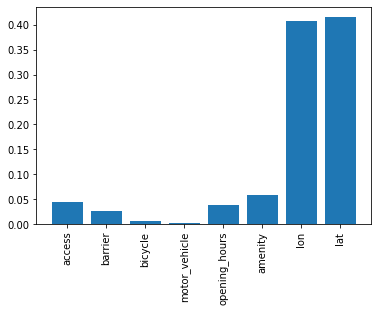

In [22]:
plt.bar(acc_X.columns, importances)
plt.xticks(rotation=90)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(acc_X, acc_y, test_size=0.20, random_state=42)

In [24]:
X_train = X_train.drop(columns='opening_hours')
X_test = X_test.drop(columns='opening_hours')

In [25]:
trial_forest = ExtraTreesClassifier(n_estimators=250, random_state=0)
trial_forest.fit(X_train, y_train)

ExtraTreesClassifier(n_estimators=250, random_state=0)

In [26]:
new_preds = trial_forest.predict(X_test)
accuracy_score(y_test, new_preds)

0.6983097148710944

## Set up XGBoost model

In [35]:
dtrain = xgb.DMatrix(X_train, label=y_train)

In [36]:
param = {'objective': 'multi:softmax', 'num_class':7}

In [37]:
num_round = 100
bst = xgb.train(param, dtrain, num_round)

[10:49:21] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [38]:
dtest = xgb.DMatrix(X_test)

In [39]:
xgb_preds = bst.predict(dtest)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

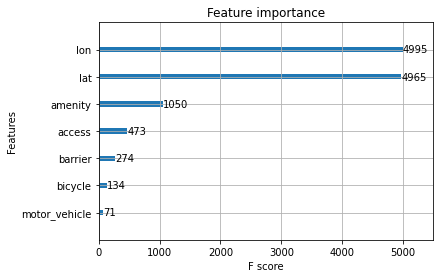

In [40]:
xgb.plot_importance(bst)

In [41]:
accuracy_score(y_test, xgb_preds)

0.7153833020317568

## Try simplistic homogenisation schemes

Given that the features which seem to be poor predictors are the ones with manually input tags, will homogenising those improve the result somewhat?

First, try simple lat_lon_wheelchair file with wheelchair accesibility binned into 4 labels

In [42]:
r_df = pd.read_pickle("accessible_pois_lon_lat_wheelchair.pkl")
r_df.head()

,lon,lat,wheelchair_cat
99878,-0.152985,51.524358,yes
104734,-1.785876,51.565653,yes
106213,-0.142942,51.525660,yes
108042,-0.135513,51.523561,limited
251191,-0.715918,51.115444,limited


In [43]:
r_df['wheelchair_cat'] = pd.Categorical(r_df['wheelchair_cat'])
r_y = r_df['wheelchair_cat'].cat.codes

In [44]:
r_y

99878         3
104734        3
106213        3
108042        1
251191        1
             ..
8495396114    3
8495396115    3
8497470120    1
8497671325    2
8497671329    1
Length: 29282, dtype: int8

In [45]:
r_X = r_df.drop(columns='wheelchair_cat')
r_X.head()

,lon,lat
99878,-0.152985,51.524358
104734,-1.785876,51.565653
106213,-0.142942,51.525660
108042,-0.135513,51.523561
251191,-0.715918,51.115444


In [46]:
r_X_train, r_X_test, r_y_train, r_y_test = train_test_split(r_X, r_y, test_size=0.20, random_state=42)

In [47]:
r_dtrain = xgb.DMatrix(r_X_train, label=r_y_train)

In [48]:
r_param = {'objective': 'multi:softmax', 'num_class':4}

In [53]:
r_num_round = 100
r_bst = xgb.train(r_param, r_dtrain, r_num_round)

[12:53:37] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [54]:
r_dtest = xgb.DMatrix(r_X_test)

In [55]:
r_preds = r_bst.predict(r_dtest)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

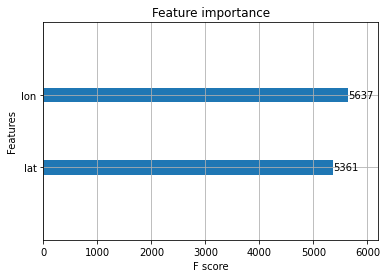

In [56]:
xgb.plot_importance(r_bst)

In [57]:
accuracy_score(r_y_test, r_preds)

0.6914802800068295

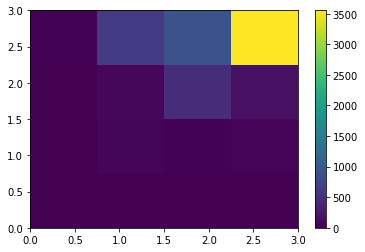

In [64]:
plt.hist2d(r_y_test, r_preds, bins=4)
plt.colorbar()

Accuracy seems to remain the same with this. Need additional features. Let's try the additional columns in the original file, but with homogenised labels.

In [65]:
acc_df.head()

,access,barrier,bicycle,motor_vehicle,opening_hours,wheelchair,amenity,lon,lat
99878,permissive,gate,no,no,dawn-dusk,yes,None,-0.152985,51.524358
104734,NONE,None,None,None,None,yes,None,-1.785876,51.565653
106213,NONE,None,None,None,None,yes,None,-0.142942,51.525660
108042,NONE,None,None,None,Mo-We 16:00-23:30; Th-Fr 16:00-01:00; Sa 16:00...,limited,pub,-0.135513,51.523561
251191,NONE,None,None,None,None,limited,None,-0.715918,51.115444


### First try data with amenities only

In [81]:
test_df = acc_df.drop(columns='opening_hours')

In [82]:
test_df = test_df.drop(columns=['access', 'barrier', 'bicycle', 'motor_vehicle'])
test_df.head()

,wheelchair,amenity,lon,lat
99878,yes,None,-0.152985,51.524358
104734,yes,None,-1.785876,51.565653
106213,yes,None,-0.142942,51.525660
108042,limited,pub,-0.135513,51.523561
251191,limited,None,-0.715918,51.115444


In [83]:
test_df = test_df.dropna()

In [84]:
test_df.head()

,wheelchair,amenity,lon,lat
108042,limited,pub,-0.135513,51.523561
262708,limited,pub,-0.726258,51.024400
271339,no,pub,-1.856858,51.353526
328762,yes,taxi,1.305108,52.626620
367457,yes,parking,-1.446450,52.984748


In [85]:
len(test_df)

11089

In [86]:
test_df['wheelchair'].value_counts()

yes                       7468
no                        1995
limited                   1583
designated                  42
no space                     1
no use other side door       0
no;yes                       0
Name: wheelchair, dtype: int64

In [87]:
for index, row in test_df.iterrows():
    if row['wheelchair'] == 'designated':
        test_df.wheelchair[index] = 'limited'
    elif row['wheelchair'] == 'no space':
        test_df.wheelchair[index] = 'no'
    elif row['wheelchair'] == 'no use other side door':
        test_df.wheelchair[index] = 'limited'
    elif row['wheelchair'] == 'no;yes':
        test_df.wheelchair[index] = 'no'

In [144]:
test_df['wheelchair'].value_counts()

yes                       7468
no                        1996
limited                   1625
designated                   0
no space                     0
no use other side door       0
no;yes                       0
Name: wheelchair, dtype: int64

In [145]:
retain_list = ['restaurant', 'cafe', 'pub', 'toilets', 'fast_food', 'atm', 'pharmacy', 'bank', 'bar', 'parking']

In [146]:
test_df = test_df[test_df['amenity'].isin(retain_list)]
test_df['amenity'].value_counts()

restaurant    1632
cafe          1567
pub           1420
toilets       1245
fast_food     1100
atm            667
pharmacy       479
bank           361
bar            323
parking        323
Name: amenity, dtype: int64

In [190]:
test_df['wheelchair'].value_counts()

yes                       6065
no                        1697
limited                   1355
designated                   0
no space                     0
no use other side door       0
no;yes                       0
Name: wheelchair, dtype: int64

In [147]:
test_df['wheelchair'] = pd.Categorical(test_df['wheelchair'])
amm_y = test_df['wheelchair'].cat.codes

In [148]:
amm_y.value_counts()

6    6065
2    1697
1    1355
dtype: int64

In [149]:
amm_y = amm_y.replace(to_replace=6, value=3)
amm_y -= 1
amm_y.value_counts()

2    6065
1    1697
0    1355
dtype: int64

In [178]:
amm_x = test_df.drop(columns='wheelchair')
#amm_x['amenity'] = pd.Categorical(amm_x['amenity'])
#amm_x['amenity'] = amm_x['amenity'].cat.codes
amm_x.head()

,amenity,lon,lat
108042,pub,-0.135513,51.523561
262708,pub,-0.726258,51.024400
271339,pub,-1.856858,51.353526
367457,parking,-1.446450,52.984748
581475,pub,-1.498968,53.682814


In [179]:
amm_x['amenity'].value_counts()

restaurant    1632
cafe          1567
pub           1420
toilets       1245
fast_food     1100
atm            667
pharmacy       479
bank           361
bar            323
parking        323
Name: amenity, dtype: int64

In [180]:
amm_x['amenity'] = pd.Categorical(amm_x['amenity'])
amm_x['amenity'] = amm_x['amenity'].cat.codes
amm_x.head()

,amenity,lon,lat
108042,7,-0.135513,51.523561
262708,7,-0.726258,51.024400
271339,7,-1.856858,51.353526
367457,5,-1.446450,52.984748
581475,7,-1.498968,53.682814


In [181]:
amm_x['amenity'].value_counts()

8    1632
3    1567
7    1420
9    1245
4    1100
0     667
6     479
1     361
2     323
5     323
Name: amenity, dtype: int64

In [182]:
amm_X_train, amm_X_test, amm_y_train, amm_y_test = train_test_split(amm_x, amm_y, test_size=0.20, random_state=42)

In [183]:
amm_dtrain = xgb.DMatrix(amm_X_train, label=amm_y_train)

In [184]:
amm_param = {'objective': 'multi:softmax', 'num_class':3}

In [185]:
amm_num_round = 100
amm_bst = xgb.train(amm_param, amm_dtrain, amm_num_round)

[16:05:02] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [186]:
amm_dtest = xgb.DMatrix(amm_X_test)
amm_preds = amm_bst.predict(amm_dtest)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

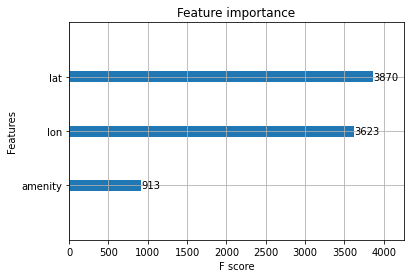

In [187]:
xgb.plot_importance(amm_bst)

In [188]:
accuracy_score(amm_y_test, amm_preds)

0.6847587719298246

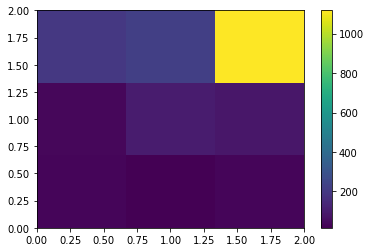

In [189]:
plt.hist2d(amm_y_test, amm_preds, bins=3)
plt.colorbar()